## Module

In [39]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn import metrics

## Preprocessing

In [2]:
#Loading the Dataframe
Dataset_std = pd.read_pickle("../Data/Data_te_std.pkl")   #Standardized Dataset
Attack_label = pd.read_pickle("../Data/Attack_label.pkl") #Attack Labels 0:Normal, 1:Attack
Attack_type_raw = pd.read_pickle("../Data/Attack_type.pkl")   #Attack Types 
mapping_dict = {'DDoS_UDP': 1, 'DDoS_ICMP': 1, 'DDoS_HTTP': 1, 'DDoS_TCP': 1,
                'Port_Scanning': 2, 'Fingerprinting': 2, 'Vulnerability_scanner': 2,
                'MITM' : 3, 'XSS' : 4, 'SQL_injection': 4, 'Uploading':4, 
                'Backdoor': 5, 'Password': 5, 'Ransomware':5, 'Normal':6}
Attack_type = Attack_type_raw.map(mapping_dict)

#Oversampling the minority classes
Dataset, Target_type = SMOTEENN(random_state= 22).fit_resample(Dataset_std, Attack_type)
Target_label = Target_type.apply(lambda x: 0 if x == 6 else 1)

#Splitting the dataset into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(Dataset, Target_type, train_size=25000, test_size=125000, random_state=22) 
_, _, Y_ref, _ = train_test_split(Dataset, Target_type, train_size=25000 ,test_size=125000, random_state=22)

## Functions

In [56]:
#Function to get the indices of the attack type
def get_index(attack_type: int, data: np.ndarray) -> np.ndarray:
    indices = np.where(data[:] == attack_type)[0]
    return indices  
#Function to remove a attack type from the dataframe
def remove_attack_type(data_X: np.ndarray, attack_type: int) -> np.ndarray:
    indices_to_remove = get_index(attack_type, Y_ref)
    new_data = np.delete(data_X, indices_to_remove, axis=0)
    return new_data

#Evaluation Function
def evaluate_clf(model, test: np.ndarray, pred: np.ndarray, display:bool = True) -> None:
    df_metric = pd.DataFrame({'Accuracy': metrics.accuracy_score(test, pred),
                              'Precison': metrics.precision_score(test, pred, average= None),
                              'Recall': metrics.recall_score(test, pred, average= None),
                              'F1-Score': metrics.f1_score(test, pred, average= None)
                            }, index= [1,2,3,4,5,6])
    if display:
        cm = metrics.confusion_matrix(test, pred, normalize= 'true', labels=model.classes_) 
        metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()
        plt.title(model[1].__class__.__name__)
    return df_metric

#Function for looping training and testing
def train_and_eval(model, x, y, display: bool = False):
    y_pred = model.fit(x, y).predict(X_test)
    return evaluate_clf(model, Y_test, y_pred, display)

#Classes for pipeline
class SampleExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, num_samples=1000):
        self.num_samples = num_samples
        self.is_fitting = False
    
    def fit(self, X, y=None):
        self.is_fitting = True
        return self
    
    def transform(self, X, y=None):
        if self.is_fitting:
            X_sampled = X[:self.num_samples]
            if y is not None:
                y_sampled = y[:self.num_samples]
                return X_sampled , y_sampled
            else:
                return X_sampled
        else:
            return X
        
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)
    
# Custom pipeline to handle different behavior during fit and predict
class CustomPipeline(Pipeline):
    def fit(self, X, y=None, **fit_params):
        Xt, yt = self._fit_transform(X, y, **fit_params)
        self.steps[-1][-1].fit(Xt, yt, **fit_params)
        return self

    def _fit_transform(self, X, y=None, **fit_params):
        for name, transform in self.steps[:-1]:
            if transform is not None:
                X, y = transform.fit_transform(X, y)
        return X, y

    def predict(self, X, **predict_params):
        for name, transform in self.steps[:-1]:
            if transform is not None:
                transform.is_fitting = False  
                X = transform.transform(X)
        return self.steps[-1][-1].predict(X, **predict_params)
    
#Function training and testing novel classes
def train_and_eval_novel(model, x, y, novel_class: int):
    y_pred = model.fit(x, y).predict(X_test)
    novel_indices = np.where(Y_test == novel_class+1)[0]
    labels = np.arange(1,7)
    percentage = {}
    for i in np.delete(labels, novel_class):
        percentage[i] = (np.where(y_pred[novel_indices] == i)[0].shape[0]/novel_indices.shape[0])*100
    return pd.DataFrame(percentage, columns= np.delete(labels, novel_class), index= ['Percentage'])


## Models

In [41]:
svc = SVC(kernel ='rbf', C= 1e4, decision_function_shape= 'ovo', probability= True)
linsvc = CalibratedClassifierCV(estimator=LinearSVC(), method='sigmoid')
knn = KNeighborsClassifier(n_neighbors= 6, weights= 'distance', algorithm= 'auto', leaf_size= 20, p= 1)
rf = RandomForestClassifier(n_estimators=80, max_samples= 0.8, max_depth=11,
                                max_features= 0.9, criterion= 'gini', random_state=22, oob_score= True)
vote_clf = VotingClassifier(estimators=[('SVC', svc), ('linear SVC', linsvc), ('KNN', knn), ('Random Forest', rf)], voting='soft')

models = {'SVC': CustomPipeline([('sample_extractor', SampleExtractor(num_samples=4000)), ('svc', svc)]),
          'Linear SVC':CustomPipeline([('sample_extractor', SampleExtractor(num_samples=4000)), ('linsvc', linsvc)]),
          'KNN':CustomPipeline([('sample_extractor', SampleExtractor(num_samples=25000)), ('knn', knn)]),
          'Random Forest':CustomPipeline([('sample_extractor', SampleExtractor(num_samples=5000)), ('rf', rf)]),
          'Voting Classifier':CustomPipeline([('sample_extractor', SampleExtractor(num_samples=10000)), ('vote_clf', vote_clf)])
          }

## Voting Multiclassifier

Accuracy  Precison    Recall  F1-Score
Model             Classes                                        
SVC               1        0.914336  0.992546  0.987314  0.989923
                  2        0.914336  0.980947  0.959713  0.970214
                  3        0.914336  0.995712  1.000000  0.997851
                  4        0.914336  0.693746  0.616677  0.652945
                  5        0.914336  0.729623  0.950299  0.825467
                  6        0.914336  0.985161  0.757221  0.856282
Linear SVC        1        0.845376  0.989537  0.737711  0.845266
                  2        0.845376  0.786592  0.978654  0.872175
                  3        0.845376  0.985867  0.999054  0.992417
                  4        0.845376  0.727537  0.402359  0.518156
                  5        0.845376  0.630566  0.960511  0.761328
                  6        0.845376  0.992358  0.699622  0.820666
KNN               1        0.944472  0.990501  0.942999  0.966167
                  2        0.944472  0.928067  0.981360  0.953969
                  3        0.944472  0.999511  1.000000  0.999755
                  4        0.944472  0.783849  0.788542  0.786188
                  5        0.944472  0.933398  0.954907  0.944030
                  6        0.944472  0.927580  0.888239  0.907483
Random Forest     1        0.970064  0.999130  0.984314  0.991667
                  2        0.970064  0.997108  0.992312  0.994704
                  3        0.970064  0.998664  1.000000  0.999332
                  4        0.970064  0.823257  0.888373  0.854576
                  5        0.970064  0.986880  0.929716  0.957446
                  6        0.970064  0.931218  0.965268  0.947937
Voting Classifier 1        0.950704  0.998053  0.988643  0.993326
                  2        0.950704  0.975583  0.990164  0.982820
                  3        0.950704  0.997851  1.000000  0.998925
                  4        0.950704  0.775270  0.807489  0.791052
                  5        0.950704  0.880517  0.949827  0.913860
                  6        0.950704  0.974225  0.853508  0.909880

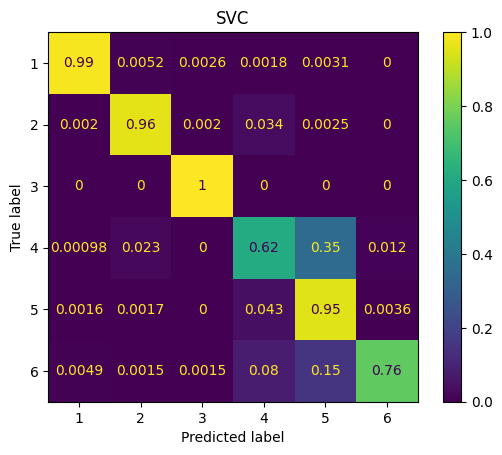

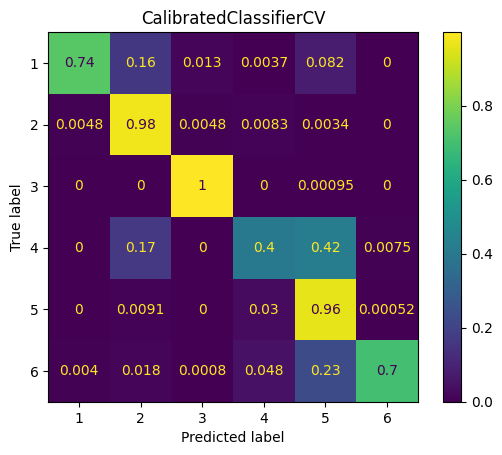

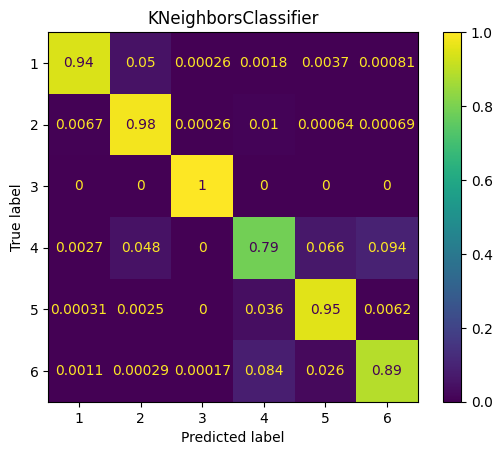

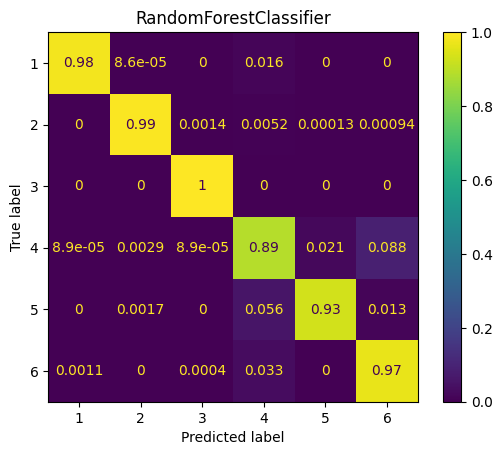

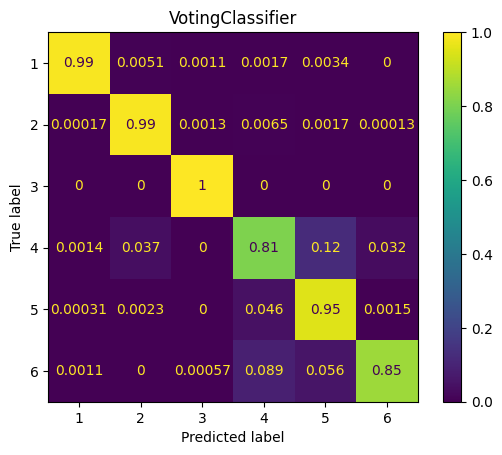

In [51]:
Results_Multiclassifier = pd.DataFrame()
for model_name, model in models.items(): 
    Results_Multiclassifier = pd.concat([Results_Multiclassifier, train_and_eval(model, X_train, Y_train, True)], axis=0, ignore_index=True)

Results_Multiclassifier.index = pd.MultiIndex.from_product([models.keys(), np.arange(1,7)], names=['Model', 'Classes'])
Results_Multiclassifier

<Axes: title={'center': 'F1-Score of the Models'}, xlabel='Model'>

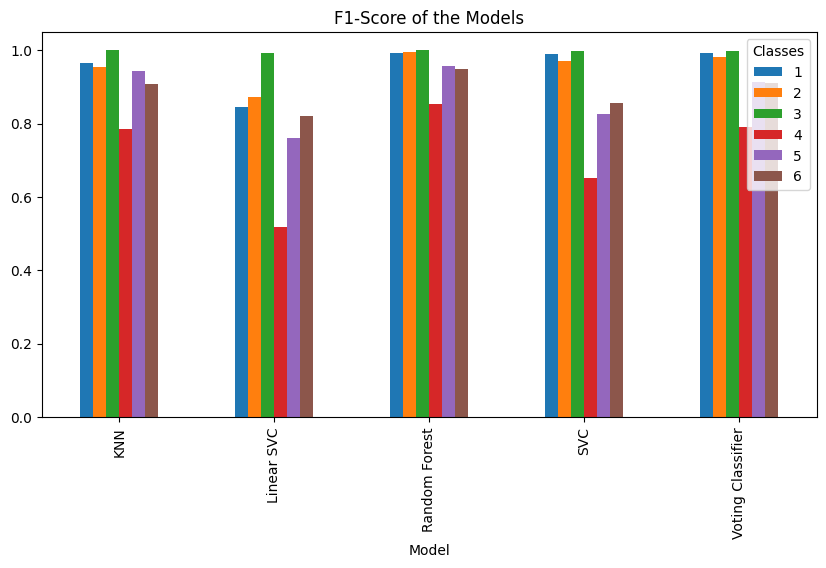

In [53]:
Results_Multiclassifier['F1-Score'].unstack().plot(kind='bar', figsize=(10,5), title='F1-Score of the Models')

## Novel Attacks

In [57]:
#Training set without the novel attack types
X_train_nov1 = remove_attack_type(np.array(X_train), 1)
Y_train_nov1 = remove_attack_type(np.array(Y_train), 1)
X_train_nov2 = remove_attack_type(np.array(X_train), 2)
Y_train_nov2 = remove_attack_type(np.array(Y_train), 2)
X_train_nov3 = remove_attack_type(np.array(X_train), 3)
Y_train_nov3 = remove_attack_type(np.array(Y_train), 3)
X_train_nov4 = remove_attack_type(np.array(X_train), 4)
Y_train_nov4 = remove_attack_type(np.array(Y_train), 4)
X_train_nov5 = remove_attack_type(np.array(X_train), 5)
Y_train_nov5 = remove_attack_type(np.array(Y_train), 5)

trainings = [(X_train_nov1, Y_train_nov1), (X_train_nov2, Y_train_nov2), (X_train_nov3, Y_train_nov3),
             (X_train_nov4, Y_train_nov4), (X_train_nov5, Y_train_nov5)]

Results_Multiclassifier_Novel = pd.DataFrame()
for model_name, model in models.items(): 
    result = pd.DataFrame()
    for i, (x, y) in enumerate(trainings):
        result = pd.concat([result, train_and_eval_novel(model, x, y, i)], axis=0, ignore_index=True)
    Results_Multiclassifier_Novel = pd.concat([Results_Multiclassifier_Novel, result], axis=0)

Results_Multiclassifier_Novel.index = pd.MultiIndex.from_product([models.keys(), ['novel type 1', 'novel type 2', 'novel type 3', 'novel type 4', 'novel type 5']],
                                                names=['Model', 'Novel Type'])
Results_Multiclassifier_Novel.replace(np.nan, 0, inplace=True)  
Results_Multiclassifier_Novel

2          3          4          5  \
Model             Novel Type                                                 
SVC               novel type 1  49.667852  41.923456   1.757168   6.651524   
                  novel type 2        NaN   5.682257  51.243396   0.261994   
                  novel type 3   0.000000        NaN   0.009787   0.000000   
                  novel type 4  18.267942   0.000000        NaN  61.935830   
                  novel type 5   0.230439   0.000000  54.147900        NaN   
Linear SVC        novel type 1  47.147816  43.937771   0.510007   8.404406   
                  novel type 2        NaN   5.673667  49.847528   0.339303   
                  novel type 3   0.000000        NaN   0.000000  30.173229   
                  novel type 4  37.304495   0.000000        NaN  50.442399   
                  novel type 5   3.404211   0.000000  49.062533        NaN   
KNN               novel type 1  52.942185  38.619123   1.928599   5.035786   
                  novel type 2        NaN   5.519048  51.887643   0.515398   
                  novel type 3   0.000000        NaN   0.000000   0.000000   
                  novel type 4  21.699884   0.000000        NaN  30.556797   
                  novel type 5   2.890961   0.000000  36.571698        NaN   
Random Forest     novel type 1  52.359319  39.321990   6.852955   1.465735   
                  novel type 2        NaN   8.362324  27.526521  35.979041   
                  novel type 3   0.000000        NaN   0.000000   0.000000   
                  novel type 4   2.600769   0.008937        NaN  58.092770   
                  novel type 5   2.581963   0.031423  51.309312        NaN   
Voting Classifier novel type 1  52.509322  39.107702   1.431449   6.947242   
                  novel type 2        NaN   5.604948  54.224112   0.360778   
                  novel type 3   0.000000        NaN   0.000000   0.000000   
                  novel type 4  23.415855   0.000000        NaN  53.516847   
                  novel type 5   2.623861   0.000000  50.644181        NaN   

                                        6           1  
Model             Novel Type                           
SVC               novel type 1   0.000000         NaN  
                  novel type 2   0.300649   42.511704  
                  novel type 3   0.000000   99.990213  
                  novel type 4  18.035571    1.760658  
                  novel type 5   1.665445   43.956217  
Linear SVC        novel type 1   0.000000         NaN  
                  novel type 2  14.950822   29.188678  
                  novel type 3  69.826771    0.000000  
                  novel type 4  12.253106    0.000000  
                  novel type 5   4.064104   43.469153  
KNN               novel type 1   1.474307         NaN  
                  novel type 2   0.120259   41.957652  
                  novel type 3  12.302222   87.697778  
                  novel type 4  46.858522    0.884798  
                  novel type 5  17.057714   43.479627  
Random Forest     novel type 1   0.000000         NaN  
                  novel type 2   1.228364   26.903750  
                  novel type 3   0.000000  100.000000  
                  novel type 4  21.145768   18.151756  
                  novel type 5  44.113334    1.963968  
Voting Classifier novel type 1   0.004286         NaN  
                  novel type 2   0.090195   39.719967  
                  novel type 3   0.000000  100.000000  
                  novel type 4  22.906426    0.160872  
                  novel type 5   3.398973   43.332984

<Axes: title={'center': 'Percentage of Novel Classes Predicted as Normal Classes'}, xlabel='Model'>

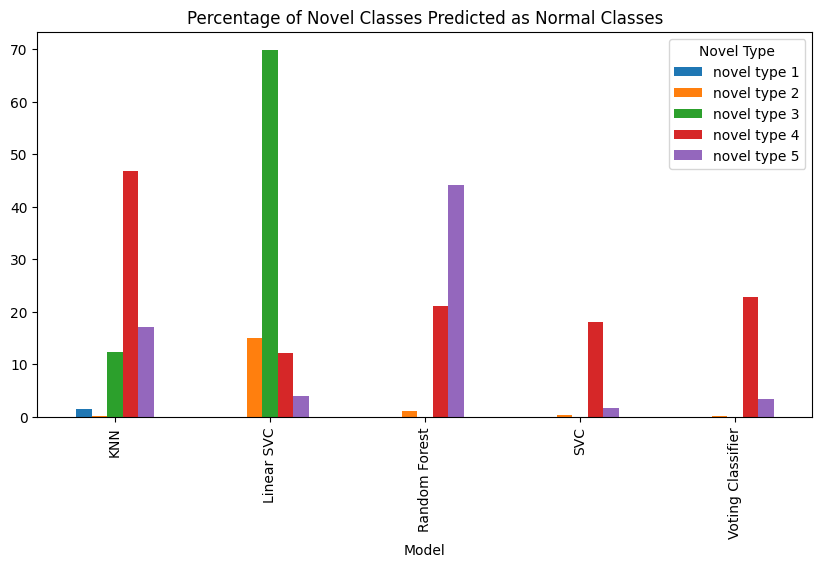

In [64]:
Results_Multiclassifier_Novel[6].unstack().plot(kind='bar', figsize=(10,5), title='Percentage of Novel Classes Predicted as Normal Classes')